In [34]:
# Import Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

import tensorflow as tf



import warnings
warnings.filterwarnings('ignore')

In [35]:
def fn_plot_tf_hist(hist_df):

    '''
    Args:
        hist_df: a dataframe with following ccolumns
            column 0: accuracy
            column 1: loss
            column 2: val_accuracy
            column 3: val_loss
            While plotting columns are accessed by index
            so that even if the column names are different it will not throw exceptions.
    '''

    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    CMAP = plt.cm.coolwarm

    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y4] == hist_df[y4].min()]

    ax = axes[0]

    hist_df.plot(y = [y2,y4], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = '{:s}: \n  train: {:6.4f}\n   test: {:6.4f}'
    txtstr = txtFmt.format(y2.capitalize(),
                           hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # calculate offset for arroe
    y_min = min(hist_df[y2].min(), hist_df[y4].min())
    y_max = max(hist_df[y2].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y4].to_numpy()[0] + offset), # location of text
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3)

    ax.set_xlabel('Epochs')
    ax.set_ylabel(y2.capitalize())
    ax.set_title('Errors')
    ax.grid(True)
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y1, y3], ax = ax, colormap=CMAP)

    # little beautification
    txtFmt = '{:s}: \n  train: {:6.4f}\n  test:  {:6.4f}'
    txtstr = txtFmt.format(y1.capitalize(),
                           hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y3].min())
    y_max = max(hist_df[y1].max(), hist_df[y3].max())
    offset = (y_max-y_min)/10.0

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y3].to_numpy()[0]-offset), # location of text
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow


    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3)

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.grid(True)
    ax.legend(loc = 'lower left')

    plt.tight_layout()




In [36]:
def fn_plot_confusion_matrix(y_true, y_pred, labels):
    '''
    Args:
        y_true: Ground Truth
        y_pred : Predictions
        labels : labels in a dictonary
                  {0: 'Goal Keeper',
                  1: 'Defender',
                  2: 'Mid-Fielder',
                  3: 'Forward'}

    '''

    cm  = confusion_matrix(y_true, y_pred)

    if isinstance(labels, dict):
        display_labels = labels.values()
    else:
        display_labels = labels

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=display_labels)

    fig, ax = plt.subplots(figsize = (4,4))

    disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)

    # Disable the grid
    ax.grid(False)

    plt.show()


In [37]:

 # Global Variables

RANDOM_STATE = 24
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

NOISE = 0.2
EPOCHS = 100
ALPHA = 0.001
BATCH_SIZE = 64
TEST_SIZE = 0.2

# set the plotting parameters
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 8),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'
         }

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid')




In [38]:
#Loading the datset
data_df = pd.read_csv('/content/fashion-mnist_train.csv')
test_df = pd.read_csv('/content/fashion-mnist_test.csv')

In [39]:
class_names = {0: 'T-shirt/top',1:'Trouser',2:'Pullover',3:'Dress',4:'Coat',
               5:'Sandal', 6: 'Shirt',7: 'Sneaker', 8:'Bag', 9: 'Ankle boot'}

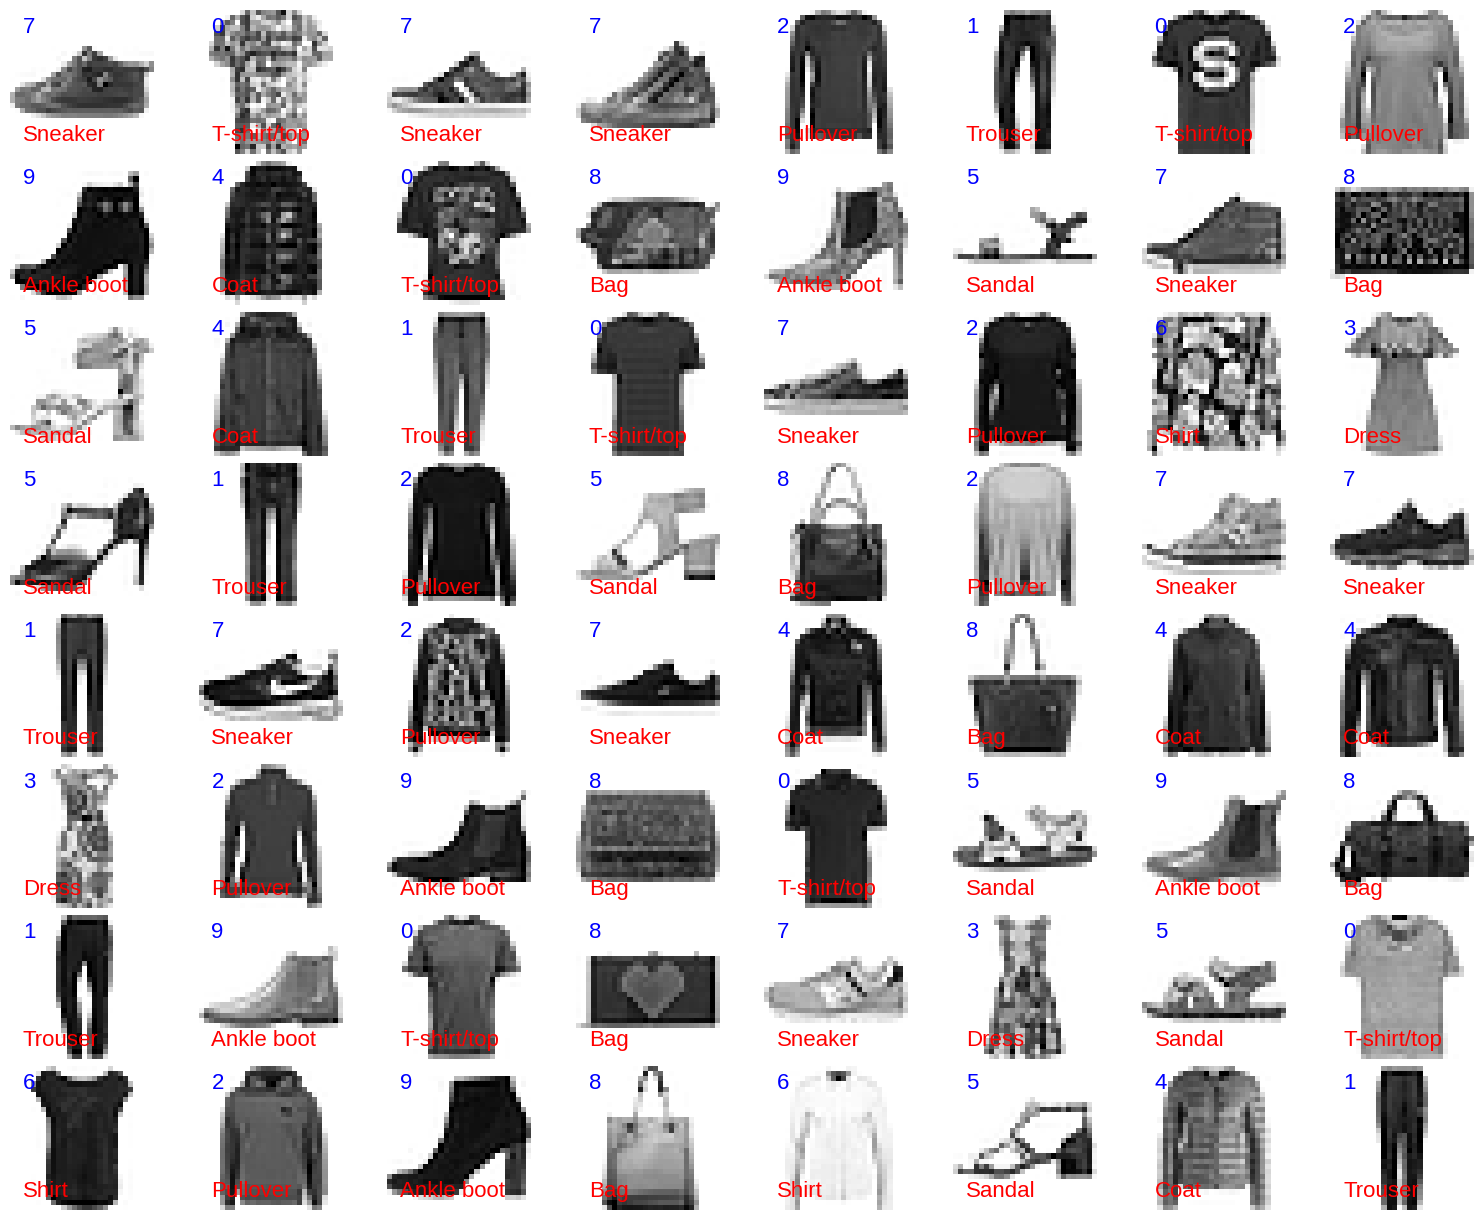

In [40]:

n_rows = 8 # number of rows to display in the grid
n_cols = 8 # number of columns to display in grid

# randomly sample n_rows * n_cols images from the dataset
plot_df = data_df.sample(n = n_rows*n_cols)

# create a new figure for the grid of images with specified sizes
fig = plt.figure(figsize = (15, 12))

# adjust spacing between subplots to eliminate gaps
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)

# initialize the subplot index
i = 0

# iterate through each row of teh sampled dataframe

for idx, row in plot_df.iterrows():

    i += 1 # incrimant subplot index

    # reshaping the row values (excluding the first columns) into a 28*28 matirx(image dimensions as given))
    image = row.values[1:].reshape(28,28)

    ax = fig.add_subplot(n_rows, n_cols, (i), xticks = [], yticks = []) # No ticks for a clean plot

    # display the image on the subplot using a binary colormap
    ax.imshow(image, cmap = plt.cm.binary, interpolation = 'nearest')

    # add the numeric label of the image in blue text at a specific possition
    ax.text(2, 4, str(row.iloc[0]), color = 'b', fontsize = 16)

    # add the class nameof the image in red text below the numeric label
    ax.text(2, 25, class_names[row.iloc[0]], color = 'r', fontsize = 16)

plt.show()

In [41]:
# Splitting train test data  using data_df

X_data = data_df.drop('label', axis = 1).to_numpy()
y_data = data_df['label'].to_numpy()

X_train,X_test,y_train,y_test = train_test_split(X_data, y_data, test_size = TEST_SIZE,
                                                 stratify=y_data, random_state=RANDOM_STATE)


# splitting validation data using test_df
X_valid = test_df.drop('label', axis = 1).to_numpy()
y_valid = test_df['label'].to_numpy()


X_train.shape, X_test.shape, y_train.shape, y_test.shape,X_valid.shape ,y_valid.shape

((48000, 784), (12000, 784), (48000,), (12000,), (10000, 784), (10000,))

In [42]:
X_train = X_train /255.0
X_test = X_test /255.0
X_valid = X_valid / 255.0

In [43]:
#Convertong into tensorflow datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
valid_ds = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))

In [44]:
train_shape = X_train.shape
test_shape = X_test.shape
valid_shape = X_valid.shape

In [45]:
# Shuffle and batch the Dataset
# by chaniging these opeartions (shuffle and batch) the dataset is first shuffle
#  and then dic=vided into batche making it ready for training ready


train_ds = train_ds.shuffle(buffer_size=X_train.shape[0]).batch(BATCH_SIZE)  #when you ran out of memory then you'll need to do this
test_ds = test_ds.shuffle(buffer_size=X_test.shape[0]).batch(BATCH_SIZE)
valid_ds = valid_ds.shuffle(buffer_size=X_valid.shape[0]).batch(BATCH_SIZE)

In [46]:
# optimize for performance
# cache the data to avoid redundant process
# repeat the dataset for multiple blocks
# prefetch data to ovelap preprocessing and model execution


train_ds = train_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)

In [47]:

#How to decide neuron
# 392 - 196 - 98 - 49 - 24 - 10

inputs = tf.keras.Input(shape= (train_shape[1],), name='input')
x = tf.keras.layers.Dense(196, activation=tf.keras.activations.relu, name='fc_1')(inputs)
x = tf.keras.layers.Dense(49, activation=tf.keras.activations.relu, name='fc_2')(x)

outputs = tf.keras.layers.Dense(10, name="Output")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs, name='MNIST')

model.summary()

Model: "MNIST"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_1 (Dense)                         │ (None, 196)                 │         153,860 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_2 (Dense)                         │ (None, 49)                  │           9,653 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 10)                  │             500 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 164,013 (640.68 KB)

 Trainable params: 164,013 (640.68 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA)

model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

In [49]:
history = model.fit(train_ds, epochs=EPOCHS,validation_data= test_ds,batch_size=BATCH_SIZE)


Epoch 1/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.7495 - loss: 0.7161 - val_accuracy: 0.8447 - val_loss: 0.4368
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8537 - loss: 0.4066 - val_accuracy: 0.8610 - val_loss: 0.3845
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8693 - loss: 0.3608 - val_accuracy: 0.8719 - val_loss: 0.3588
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8803 - loss: 0.3287 - val_accuracy: 0.8758 - val_loss: 0.3479
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8878 - loss: 0.3089 - val_accuracy: 0.8808 - val_loss: 0.3345
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8951 - loss: 0.2897 - val_accuracy: 0.8842 - val_loss: 0.3295
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8999 - loss: 0.2750 - val_accuracy: 0.8855 - val_loss: 0.3240
Epoch 8/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9045 - loss: 0.2625 - val_accu

In [50]:
hist_df = pd.DataFrame(history.history)  #dictionary
hist_df.head()

,accuracy,loss,val_accuracy,val_loss
0,0.809729,0.536649,0.844667,0.436829
1,0.858000,0.392066,0.861000,0.384474
2,0.873271,0.349475,0.871917,0.358820
3,0.883354,0.320058,0.875833,0.347865
4,0.890604,0.299995,0.880833,0.334544


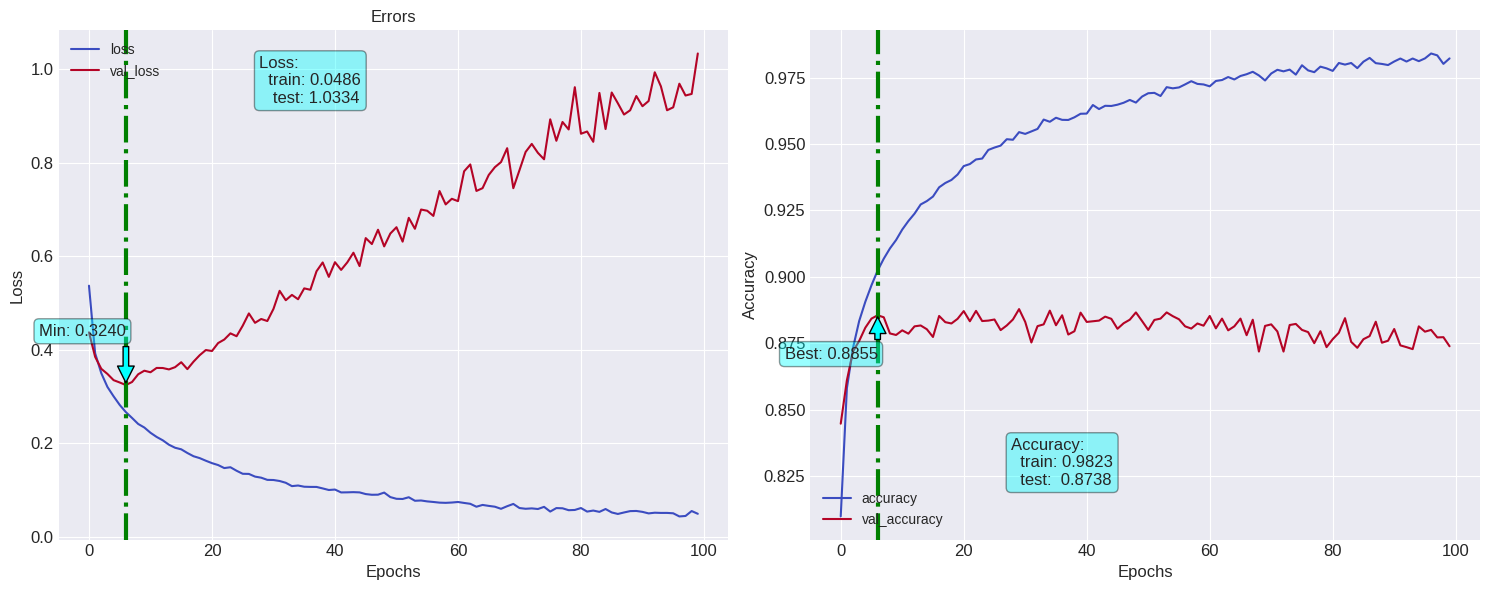

In [51]:
fn_plot_tf_hist(hist_df)